In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pickle
from IPython.display import YouTubeVideo
import warnings
warnings.simplefilter('ignore', UserWarning)
import time
import os
if not os.path.exists('../data/gan-sin'):
    os.mkdir('../data/gan-sin')

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


Keras 2.2.4
GPU: []


# Generative Adversarial Networks

https://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html

Basic parameters:

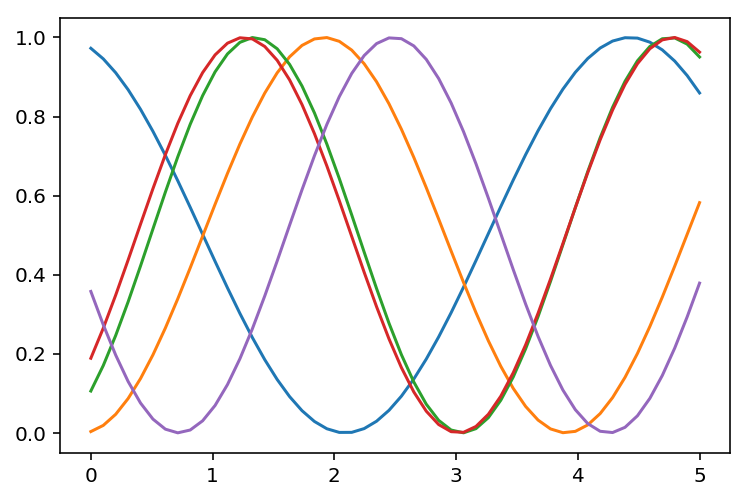

In [2]:
npts = 50
nsamples = 10000

t = np.linspace(0, 5, npts)
vectors = []

offset = np.random.random(size=nsamples) * 100
offset = offset.reshape((-1, 1))
mul = 1 + np.random.random(size=nsamples)
mul = mul.reshape((-1, 1))
vectors = np.sin(offset + t * mul) / 2 + 0.5

ntest = 100
offset = np.random.random(size=ntest) * 100
offset = offset.reshape((-1, 1))
mul = 1 + np.random.random(size=ntest)
mul = mul.reshape((-1, 1))
test_vectors = np.sin(offset + t * mul) / 2 + 0.5

for y in vectors[:5]:
    plt.plot(t, y)

## Discriminator

In [3]:
vector_shape = [50]

layers = [
    keras.layers.Reshape(target_shape=(-1, 1), input_shape=vector_shape),
    keras.layers.Conv1D(50, 5, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(50),
    keras.layers.Dense(1, activation='sigmoid') # binomial classifier
]
nn = keras.models.Sequential(layers)

vector = keras.Input(shape=vector_shape)
calssification = nn(vector)

In [4]:
discriminator = keras.models.Model(vector, calssification, name='discriminator')
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

## Generator

In [5]:
noise_shape = (10,)

layers = [
    keras.layers.Dense(256, input_shape=noise_shape),
    keras.layers.Activation('tanh'),
    keras.layers.Dense(npts),
    keras.layers.Activation('tanh'),
]
nn = keras.models.Sequential(layers)

noise = keras.Input(shape=noise_shape)
vector = nn(noise)

In [6]:
generator = keras.models.Model(noise, vector, name='generator')
generator.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

The generator takes noise as input and generated imgs

In [7]:
vector = generator(noise)

The combined model will take noise and digit and produce "fake"/"real" boolean and an image classification label.

For the combined model we will only train the generator

In [8]:
discriminator.trainable = False

The valid takes generated images as input and determines validity

In [9]:
valid = discriminator(vector)

## Combined model

The chained generator and discriminator model takes
noise as input => generates vectors => determines validity 

In [10]:
combined = keras.models.Model(noise, valid)
combined.compile(
    loss='binary_crossentropy',
    optimizer=generator.optimizer,
    metrics=['accuracy']
)

## Saving generated vectors

In [11]:
def save_vecs(idx):
    noise = np.random.normal(0, 1, (4, 10))
    gen_vecs = generator.predict(noise)

    fig, axs = plt.subplots(2, 2)
    cnt = 0
    for i in range(2):
        for j in range(2):
            axs[i,j].plot(gen_vecs[cnt, :])
            cnt += 1
    fig.savefig("../data/gan-sin/sin_{:05d}.png".format(idx))
    plt.close()

## Training

In [12]:
epochs = 100
batch_size = 32
batches_per_epoch = nsamples//batch_size
half_batch = batch_size // 2
save_interval = 1
print_interval = 1
nvecs = vectors.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

In [13]:
for epoch in range(epochs):
    for batch in range(batches_per_epoch):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of vectors
        idx = np.random.randint(0, nvecs, half_batch)
        real_vecs = vectors[idx]

        noise = np.random.normal(0, 1, (half_batch, 10))

        # Generate a half batch of new images
        gen_vecs = generator.predict(noise)

        # Train the discriminator
        vecs = np.concatenate((real_vecs, gen_vecs))
        valid = np.concatenate((np.ones(half_batch), np.zeros(half_batch)))
        dloss, dacc = discriminator.train_on_batch(
            vecs, 
            valid
        )

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))

        # The generator wants the discriminator to label the generated samples as valid (ones)
        valid = np.ones(batch_size)

        # Train the generator
        gloss, gacc = combined.train_on_batch(
            noise, 
            valid
        )

        train_history['dloss'].append( dloss )
        train_history['gloss'].append( gloss )
        train_history['dacc'].append( dacc )
        train_history['gacc'].append( gacc )
    
    # test discriminator
    noise = np.random.normal(0, 1, (ntest, 10))
    gen_vecs = generator.predict(noise)
    x = np.concatenate((test_vectors, gen_vecs))
    y_valid = np.ones(ntest*2)
    y_valid[ntest:] = 0
    
    dloss, dacc = discriminator.evaluate(x, y_valid, verbose=0)
    
    # test generator
    noise = np.random.normal(0, 1, (ntest, 10))
    valid_y = np.ones(ntest)    
    gloss, dloss = combined.evaluate(noise, valid_y, verbose=0)
    
    test_history['dloss'].append( dloss )
    test_history['dacc'].append( dacc )
    test_history['gloss'].append( gloss )
    test_history['gacc'].append( gacc )
    
    # If at save interval => save generated vector samples
    if epoch % save_interval == 0:
        save_vecs(epoch//save_interval)

In [14]:
generator.save('../data/gan_sin_generator.h5')
discriminator.save('../data/gan_sin_discriminator.h5')
combined.save('../data/gan_sin_combined.h5')

In [15]:
with open('../data/gan_sin_history.p', 'wb') as f:
    pickle.dump([train_history, test_history], f)

Plot history:

In [16]:
with open('../data/gan_sin_history.p', 'rb') as f:
    train_history, test_history = pickle.load(f)

In [17]:
dloss = np.array(test_history['dloss'])
gloss = np.array(test_history['gloss'])
dacc = np.array(test_history['dacc'])
gacc = np.array(test_history['gacc'])

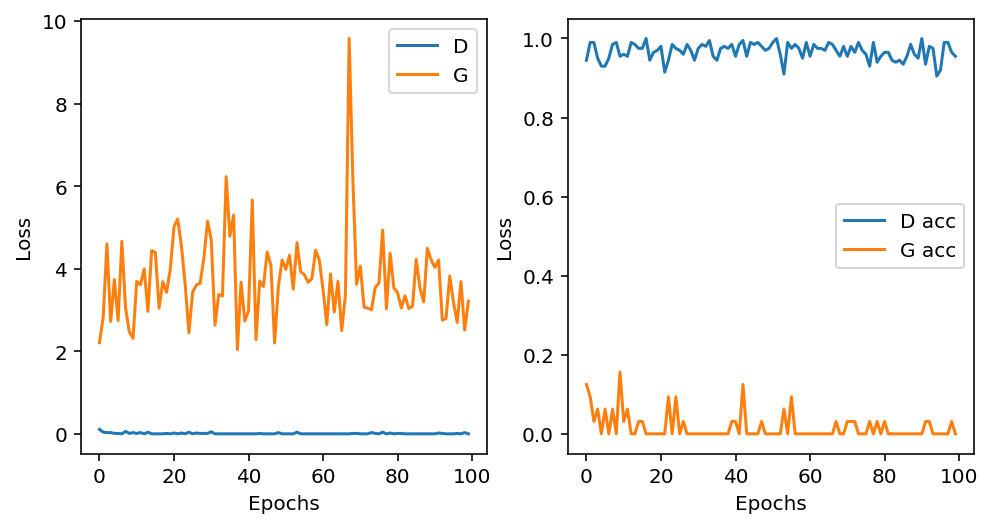

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

axes[0].plot(dloss, label='D')
axes[0].plot(gloss, label='G')
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Loss')
axes[1].plot(dacc, label='D acc')
axes[1].plot(gacc, label='G acc')
axes[1].set(xlabel='Epochs', ylabel='Loss')
axes[1].legend();

In [19]:
%ls ../data/gan-sin

sin_00000.png  sin_00020.png  sin_00040.png  sin_00060.png  sin_00080.png
sin_00001.png  sin_00021.png  sin_00041.png  sin_00061.png  sin_00081.png
sin_00002.png  sin_00022.png  sin_00042.png  sin_00062.png  sin_00082.png
sin_00003.png  sin_00023.png  sin_00043.png  sin_00063.png  sin_00083.png
sin_00004.png  sin_00024.png  sin_00044.png  sin_00064.png  sin_00084.png
sin_00005.png  sin_00025.png  sin_00045.png  sin_00065.png  sin_00085.png
sin_00006.png  sin_00026.png  sin_00046.png  sin_00066.png  sin_00086.png
sin_00007.png  sin_00027.png  sin_00047.png  sin_00067.png  sin_00087.png
sin_00008.png  sin_00028.png  sin_00048.png  sin_00068.png  sin_00088.png
sin_00009.png  sin_00029.png  sin_00049.png  sin_00069.png  sin_00089.png
sin_00010.png  sin_00030.png  sin_00050.png  sin_00070.png  sin_00090.png
sin_00011.png  sin_00031.png  sin_00051.png  sin_00071.png  sin_00091.png
sin_00012.png  sin_00032.png  sin_00052.png  sin_00072.png  sin_00092.png
sin_00013.png  sin_00033.png  sin_0005

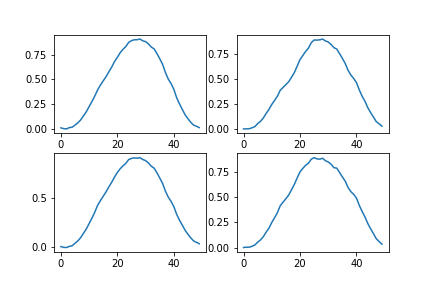

In [20]:
from keras.preprocessing import image

image.load_img('../data/gan-sin/sin_00099.png')